In [2]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from problema_1 import plot_bar_chart
# Importo el paquete para graficar
from matplotlib import pyplot as plt

# Naive bayes - Clasificación

### Bibliografía recomendada
https://nlp.stanford.edu/IR-book/ - Capitulo 13 -  
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

## Ejemplos

![](./images/student-admission.png)

![](./images/chip-test.png)

## Introducción teórica

### Teorema de Bayes
$P(y|x_1,x_2,...,x_n) = \large \frac{P(x_1, x_2,...,x_n|y) P(y)}{P(x_1,x_2,...,x_n)}$

El numerador:

$ \large P(x_1, x_2,...,x_n|y) P(y) = P(y, x_1, x_2,...,x_n)$

Por la regla de la cadena:

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2,x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

#### Ejemplo con Aplicación SPAM

$P(comprar,oferta,ganaste,SPAM) = P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)$

Asumiendo independencia

$P(x_i|y) = P(x_i|y,x_1,...)$

Calcular P(comprar|oferta,ganaste,SPAM) es impráctico y no es relevante estadísticamente. Asumimos independencia de las variables entre si. Y llegamos a una aproximacion como la siguiente:

$P(comprar,oferta,ganaste,SPAM) = P(comprar | SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)$

### Naive Bayes

$P(y|x_1,x_2,...,x_n) = \large \frac{P(y)\prod P(x_i/y)} {P(x_1,x_2,...,x_n)} = \alpha {P(y)\prod P(x_i/y)}$

(Compararlo con teorema de Bayes)
No nos interesa calcular el denominador (probabilidad conjunta de todas las palabras). Nos interesa saber cual es la clase que genera el mayor numerador, no lo dividimos para obtener la probabilidad. Nos interesa saber la clase, no la probabilidad, para eso usamos la funcion argmax, que prueba en todas las clases y te retorna la que dio el mayor valor.

$\large \hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

Ejemplo SPAM: 

La variable aleatoria $y$ puede ser: [SPAM, NO_SPAM]. Calculo ${P(y)\prod P(x_i/y)}$ para ambos casos y me quedo con el mayor

Como el denominador es el mismo para ambos casos, no hace falta calcularlo

## Detección de SPAM
V. Metsis, I. Androutsopoulos and G. Paliouras (2006). Spam filtering with Naive Bayes – Which Naive Bayes? 3rd Conf. on Email and Anti-Spam (CEAS).
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1EEA3C5EE5DDF8409BCC0F09BFB7D98B?doi=10.1.1.61.5542&rep=rep1&type=pdf

Tenemos un dataset donde ya esta preprocesado el texto
- Lemmatization, stemming
- Stop words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
#CountVectorizer --> De una lista de texto devuelve una matriz con las palabras y mails, y las cantidades que aparecen en cada mail

#xxxxxx palabra1 palabra2
#mail1  1        7
#mail2  5        0
import numpy as np

In [5]:
import os
from collections import Counter
train_dir = './ling-spam/train-mails'
emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 

In [6]:
emails[0:10]

['./ling-spam/train-mails\\3-1msg1.txt',
 './ling-spam/train-mails\\3-1msg2.txt',
 './ling-spam/train-mails\\3-1msg3.txt',
 './ling-spam/train-mails\\3-375msg1.txt',
 './ling-spam/train-mails\\3-378msg1.txt',
 './ling-spam/train-mails\\3-378msg2.txt',
 './ling-spam/train-mails\\3-378msg3.txt',
 './ling-spam/train-mails\\3-378msg4.txt',
 './ling-spam/train-mails\\3-378msg5.txt',
 './ling-spam/train-mails\\3-379msg1.txt']

In [7]:
with open(emails[5]) as m:
    print(m)
    for i,line in enumerate(m):
        print(i, line)

<_io.TextIOWrapper name='./ling-spam/train-mails\\3-378msg2.txt' mode='r' encoding='cp1252'>
0 Subject: l2 learn / cultural empathy

1 

2 graduate student education approach colleague mine query linguist able help . evaluation exchange program indonesium one object prepare high school teacher indonesium here australium . wonder anything write correlation degree acquisition l2 degree empathy participation culture l2 speaker . high involvement / skill seem thing teacher both area ; however negative aspect . apparently seem correlation between development skill language drop teach . due " culture shock " return australium those become most deeply immerse ? reference / idea gratefully receive . number , summarise . patrick mcconvell , anthropology , northrn territory university , po box 40146 , casuarina , nt 0811 , australium



In [8]:
def make_Dictionary(train_dir):
    # Train dir es la carpeta para parsear
    emails_array = []
    labels = []
    # Emails es una lista con los nombres de los archivos
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 
    # All words contendrá todas las palabras del mail
    all_words = []       
    for mail in emails:
        # mail es el nombre del archivo
        with open(mail) as m:
            # m es el archivo abierto
            if 'spmsg' in mail.split('/')[-1]:
                # Si el nombre del archivo contiene 'spmsg' es spam
                labels.append(True)
            else:
                labels.append(False)
            # email_str va a guardar el mail como string
            email_str = ''
            for i,line in enumerate(m):
                if i == 2:  #Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
                    email_str = email_str + ' ' + line
            emails_array.append(email_str)
    dictionary = Counter(all_words)
    return dictionary, emails_array, labels

def remove_uncommon_words(dictionary):
    # Dictionary es un counter
    dict_copy = { k : v for k,v in dictionary.items()}
    list_to_remove = dictionary.keys()
    for item in list_to_remove:
        if item.isalpha() == False: 
            # Remueve lo que no sean palabras con letras del abcedario
            del dict_copy[item]
        elif len(item) == 1:
            # Remueve las palabras de una letra
            del dict_copy[item]
    return Counter(dict_copy)

In [9]:
def read_emails_and_get_dict(folder, max_features=3000):
    dictionary, emails_array, labels = make_Dictionary(folder)
    dictionary = remove_uncommon_words(dictionary)
    dictionary = dictionary.most_common(max_features)
    vocabulary = [key[0] for key in dictionary]
    return vocabulary, emails_array, np.array(labels)

In [10]:
max_features = 3000

In [11]:
vocabulary, emails_array, labels = read_emails_and_get_dict('./ling-spam/train-mails', max_features)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
feature_matrix = count_vectorizer.fit_transform(emails_array)

In [12]:
print(labels[0:10])
print(vocabulary[0:10])
print(feature_matrix)

[False False False False False False False False False False]
['order', 'address', 'report', 'mail', 'send', 'language', 'email', 'program', 'our', 'list']
  (0, 5)	1
  (0, 9)	1
  (0, 11)	4
  (0, 22)	1
  (0, 37)	1
  (0, 42)	1
  (0, 47)	1
  (0, 51)	1
  (0, 57)	1
  (0, 116)	1
  (0, 118)	1
  (0, 140)	1
  (0, 143)	1
  (0, 207)	1
  (0, 260)	1
  (0, 273)	1
  (0, 289)	1
  (0, 298)	1
  (0, 318)	3
  (0, 337)	1
  (0, 375)	1
  (0, 384)	1
  (0, 430)	1
  (0, 453)	1
  (0, 470)	2
  :	:
  (701, 180)	1
  (701, 204)	1
  (701, 253)	1
  (701, 299)	1
  (701, 378)	1
  (701, 434)	1
  (701, 513)	1
  (701, 569)	1
  (701, 604)	2
  (701, 646)	1
  (701, 667)	1
  (701, 821)	1
  (701, 854)	1
  (701, 867)	1
  (701, 949)	1
  (701, 963)	1
  (701, 999)	1
  (701, 1150)	1
  (701, 1220)	1
  (701, 1239)	1
  (701, 1243)	1
  (701, 1281)	1
  (701, 1856)	1
  (701, 2044)	1
  (701, 2496)	1


In [13]:
print(feature_matrix.sum(axis=0).shape)
print(feature_matrix.sum(axis=0))#Suma todos lo valores de cada columna
print(feature_matrix.sum(axis=0) + 1)#El uno es el alfa, se usa para evitar que haya valores cero y que el producto de P(palabra|spam) no sea cero
print((feature_matrix.sum(axis=0) + 1).sum())

(1, 3000)
[[1423 1302 1216 ...,    8    8    8]]
[[1424 1303 1217 ...,    9    9    9]]
157993


In [14]:
def get_histogram_from_matrix(alpha, feature_matrix):
    # Alpha es para suavizar y evitar la probabilidad cero. Normalmente 1
    # Es como agregar un mail con todas las palabras
    words_distribution_un = feature_matrix.sum(axis=0) + alpha
    words_distribution = words_distribution_un/(words_distribution_un.sum()) # + alpha*feature_matrix.shape[1])
    return words_distribution

spam_feature_matrix = feature_matrix[labels,:]
ham_feature_matrix = feature_matrix[np.logical_not(labels),:]

print('SPAM:',labels.nonzero()[0].shape[0],
      'HAM:',np.logical_not(labels).nonzero()[0].shape[0],
      'total:',len(labels))

print()
print('Palabras diferentes')
print('SPAM:', spam_feature_matrix.nonzero()[0].shape[0],
      'HAM:',ham_feature_matrix.nonzero()[0].shape[0])

print()
print('Cantidad de palabras')
print('SPAM:',spam_feature_matrix.sum(), 'HAM:',ham_feature_matrix.sum())


# P(x_i/SPAM)
spam_words_distribution = get_histogram_from_matrix(1, spam_feature_matrix)
# P(x_i/HAM)
ham_words_distribution = get_histogram_from_matrix(1, ham_feature_matrix)

SPAM: 351 HAM: 351 total: 702

Palabras diferentes
SPAM: 49126 HAM: 33482

Cantidad de palabras
SPAM: 97941 HAM: 57052


$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

$y = [SPAM, HAM]$

In [15]:
def plot_bar_chart(P, vocabulary = None, title='title'):
    N = len(P)
    plt.figure(figsize=(20, 5)) # Tamaño del gráfico
    indexes = list(range(1, len(P) + 1))
    plt.bar(indexes, P, width=0.75, color='b') # Grafico
    plt.title(title)

    # Definición de indices
    if not vocabulary:
        string_indexes = [str(i) for i in indexes]
    else:
        string_indexes = [vocabulary[i-1] for i in indexes]
    plt.xlim([0,N+1])
    plt.xticks(indexes, string_indexes) 
    plt.xticks(rotation=60)
    plt.show()

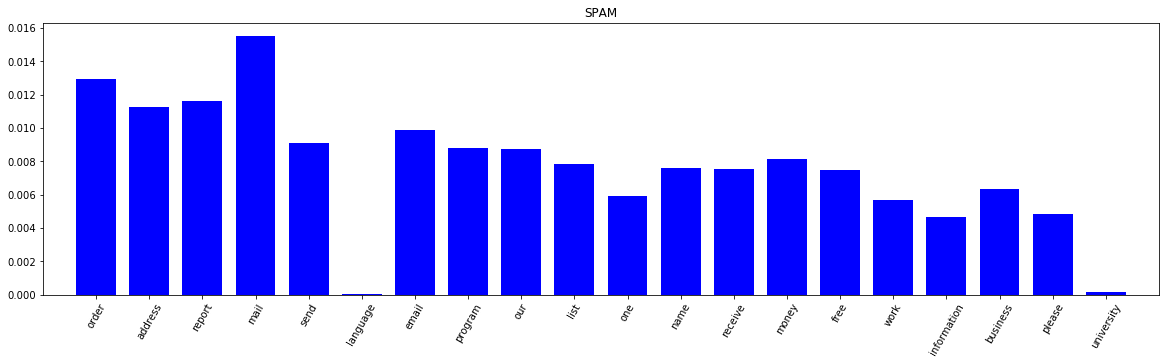

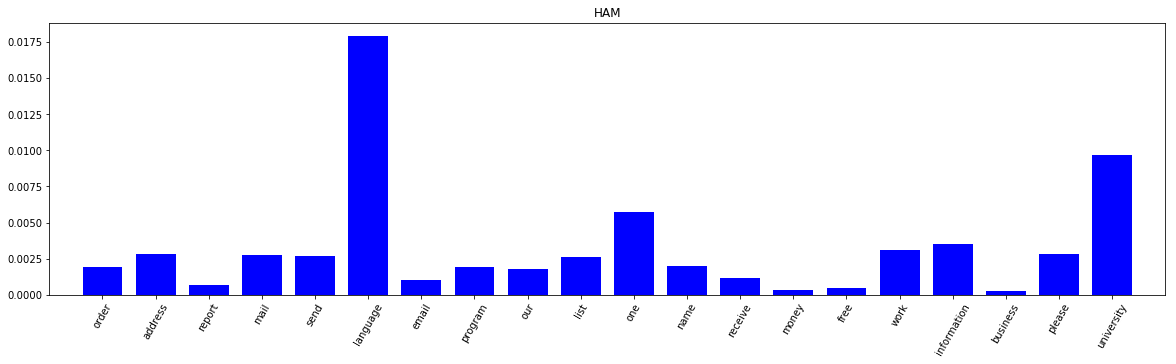

In [16]:
import matplotlib.pyplot as plt

N = 20
plot_bar_chart(np.array(spam_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='SPAM')
plot_bar_chart(np.array(ham_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='HAM')

In [17]:
# Veamos si el primer email es SPAM o no
# El primer mail corresponde a la primer fila de la matriz
row = feature_matrix[1,:]
print('Primer email codificado:')
print(row)

non_zero_row = row.nonzero()
print('Elementos distintos de cero:',non_zero_row[1])
print('Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador')
print(spam_words_distribution[0, non_zero_row].prod())
print(ham_words_distribution[0, non_zero_row].prod())
print('Log likelihood')
#Para evitar los valores pequeños usamos logaritmo.
print(np.log(spam_words_distribution[0, non_zero_row]).sum())
print(np.log(ham_words_distribution[0, non_zero_row]).sum())

Primer email codificado:
  (0, 5)	1
  (0, 10)	1
  (0, 19)	1
  (0, 22)	1
  (0, 43)	1
  (0, 50)	1
  (0, 86)	1
  (0, 130)	1
  (0, 197)	1
  (0, 256)	1
  (0, 313)	1
  (0, 402)	1
  (0, 438)	1
  (0, 556)	1
  (0, 813)	1
  (0, 852)	1
  (0, 970)	1
  (0, 1034)	1
  (0, 1077)	1
  (0, 1152)	1
  (0, 1212)	2
  (0, 1285)	1
  (0, 1481)	1
  (0, 1594)	1
  (0, 1721)	1
  (0, 2082)	1
  (0, 2083)	1
Elementos distintos de cero: [   5   10   19   22   43   50   86  130  197  256  313  402  438  556  813
  852  970 1034 1077 1152 1212 1285 1481 1594 1721 2082 2083]
Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador
8.22779583786e-153
1.06365409857e-158
Log likelihood
-350.18800107
-363.74673445


¿Por que usamos log likelihood? Para transformar la productoria en una suma y evitar los valores pequeños con exponentes grandes negativos

In [18]:
def get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution):
    P_SPAM = labels.nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    P_HAM = np.logical_not(labels).nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    correct_count = 0
    for i, row in enumerate(feature_matrix):
        coded_email = row.nonzero()
        spam_log_likelihood = np.log(spam_words_distribution[coded_email]).sum() + np.log(P_SPAM)
        ham_log_likelihood = np.log(ham_words_distribution[coded_email]).sum() + np.log(P_HAM)
        SPAM = spam_log_likelihood>=ham_log_likelihood
        if SPAM == labels[i]:
            correct_count = correct_count + 1
    print('%0.3f'%(correct_count/len(labels)))

In [19]:
get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution)
#Accuracy de entrenamiento

0.989


## Test set

In [20]:
_, emails_array, labels_test = read_emails_and_get_dict('./ling-spam/test-mails', max_features)
count_vectorizer_test = CountVectorizer(vocabulary=vocabulary)
feature_matrix_test = count_vectorizer.fit_transform(emails_array)

In [21]:
get_accuracy(feature_matrix_test, labels_test, spam_words_distribution, ham_words_distribution)

0.965


# Sklearn MultinomialNB

In [22]:
from sklearn.naive_bayes import MultinomialNB #tiene en cuenta la repeticion de palabras en el mail

In [23]:
clf = MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [24]:
clf.fit(feature_matrix, labels)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [25]:
clf.score(feature_matrix, labels)

0.99002849002849003

In [26]:
clf.score(feature_matrix_test, labels_test)

0.96153846153846156

In [27]:
clf.predict(feature_matrix_test[100:150])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [28]:
clf.predict_proba(feature_matrix_test[100:150])
#Probabilidad con la que predijo

array([[  1.00000000e+000,   7.32380010e-220],
       [  1.00000000e+000,   3.25879515e-079],
       [  1.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   1.26134208e-066],
       [  1.00000000e+000,   3.94200228e-083],
       [  1.00000000e+000,   4.84552864e-035],
       [  1.00000000e+000,   2.10949360e-202],
       [  1.00000000e+000,   1.04146216e-169],
       [  1.00000000e+000,   1.60341690e-097],
       [  1.00000000e+000,   2.22593372e-210],
       [  1.00000000e+000,   1.23514535e-220],
       [  1.00000000e+000,   1.25032875e-056],
       [  1.00000000e+000,   1.01956051e-088],
       [  1.00000000e+000,   9.59502751e-132],
       [  1.00000000e+000,   1.69312252e-167],
       [  1.00000000e+000,   1.11111736e-014],
       [  1.00000000e+000,   6.39730069e-196],
       [  1.00000000e+000,   1.44610245e-107],
       [  1.00000000e+000,   5.08208587e-054],
       [  1.00000000e+000,   3.94215097e-201],
       [  1.0

# Sklearn BernoulliNB
Suele ser interesante evaluar Multinomial y Bernoulli para comparar resultados. A veces para textos cortos BernoulliNB puede dar mejores resultados

In [29]:
from sklearn.naive_bayes import BernoulliNB #solo tiene en cuenta si la palabra aparece o no aparece, no la cantidad de ocurrencias
#por eso da peor score con este modelo, porque no tiene en cuenta las ocurrencias. Funciona mejor con mails cortos.

In [30]:
clf_Ber = BernoulliNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False, binarize=0.5)

In [31]:
clf_Ber.fit(feature_matrix, labels)

BernoulliNB(alpha=1, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

In [32]:
clf_Ber.score(feature_matrix, labels)

0.86467236467236464

In [33]:
clf_Ber.score(feature_matrix_test, labels_test)

0.76923076923076927

# ¿Es posible graficar un problema de dimensión 3000 en 2 dimensiones?

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = feature_matrix.todense()
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

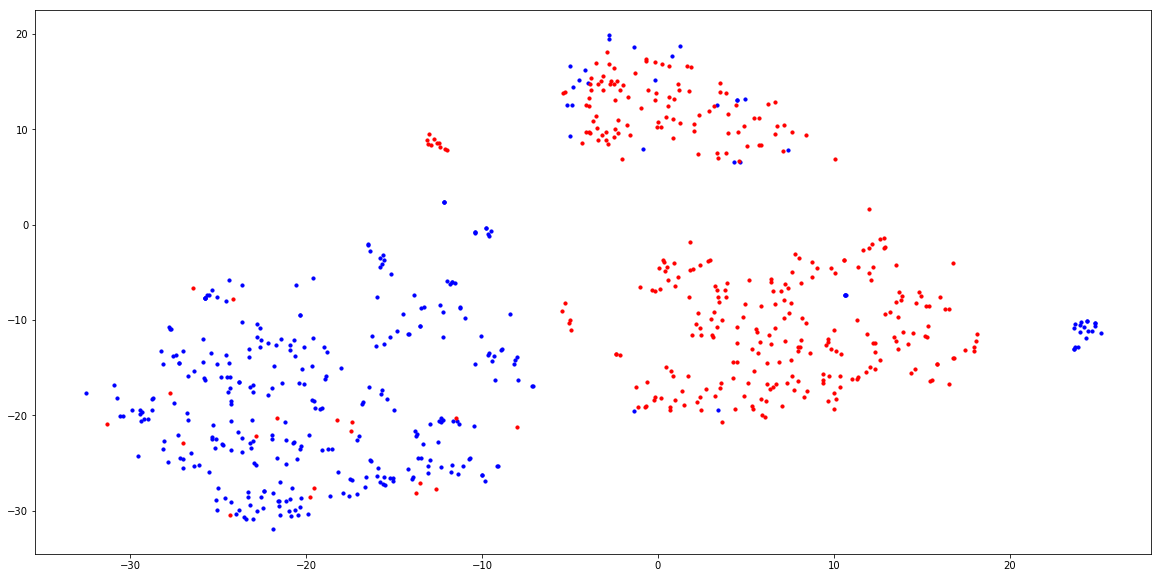

In [35]:
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[labels,0], X_embedded[labels,1], color='b', s=10)
plt.scatter(X_embedded[np.logical_not(labels),0], X_embedded[np.logical_not(labels),1], color='r', s=10)
plt.show()

# Gaussian NB
https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Sex_classification

A diferencia de las multinomiales y de bernoulli (utilizado para valores discretos) las gaussiana responde a datos con distribucion gaussiana.

In [36]:
# Datos originales de wikipedia
data = [
    {"genero":'hombre', 'altura': 6, 'peso': 180,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 190,'pie':11}, 
    {"genero":'hombre', 'altura': 5.58, 'peso': 170,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 165,'pie':10}, 
    {"genero":'mujer', 'altura': 5, 'peso': 100,'pie':6}, 
    {"genero":'mujer', 'altura': 5.5, 'peso': 150,'pie':8}, 
    {"genero":'mujer', 'altura': 5.42, 'peso': 130,'pie':7}, 
    {"genero":'mujer', 'altura': 5.75, 'peso': 150,'pie':9}, 
]

In [37]:
# Altura en cm y peso en kg
data = [{'altura': 183, 'genero': 'hombre', 'peso': 82, 'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 86, 'pie': 11},
         {'altura': 170,'genero': 'hombre','peso': 77,'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 75, 'pie': 10},
         {'altura': 152, 'genero': 'mujer', 'peso': 45, 'pie': 6},
         {'altura': 167, 'genero': 'mujer', 'peso': 68, 'pie': 8},
         {'altura': 165, 'genero': 'mujer', 'peso': 59, 'pie': 7},
         {'altura': 175, 'genero': 'mujer', 'peso': 68, 'pie': 9}]

In [38]:
GNB_features_matrix = np.zeros((len(data),3))
GNB_labels = np.empty((len(data)), dtype=object)
print('Matriz y lista antes de llenar')
print(GNB_features_matrix)
print(GNB_labels)

for i, person in enumerate(data):
    GNB_features_matrix[i, 0] = person['altura']
    GNB_features_matrix[i, 1] = person['peso']
    GNB_features_matrix[i, 2] = person['pie']
    GNB_labels[i] = person['genero']
print()
print('Matriz y lista con los datos:')
print(GNB_features_matrix)
print(GNB_labels)

Matriz y lista antes de llenar
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[None None None None None None None None]

Matriz y lista con los datos:
[[ 183.   82.   12.]
 [ 180.   86.   11.]
 [ 170.   77.   12.]
 [ 180.   75.   10.]
 [ 152.   45.    6.]
 [ 167.   68.    8.]
 [ 165.   59.    7.]
 [ 175.   68.    9.]]
['hombre' 'hombre' 'hombre' 'hombre' 'mujer' 'mujer' 'mujer' 'mujer']


In [39]:
men_means = GNB_features_matrix[GNB_labels=='hombre',:].mean(axis=0)
women_means = GNB_features_matrix[GNB_labels=='mujer',:].mean(axis=0)
men_vars = GNB_features_matrix[GNB_labels=='hombre',:].var(axis=0, ddof=1)
women_vars = GNB_features_matrix[GNB_labels=='mujer',:].var(axis=0, ddof=1)
print('medias de los hombres:', men_means)
print('varianzas de los hombres:', men_vars)
print('medias de las mujeres:', women_means)
print('varianzas de las mujeres:', women_vars)

medias de los hombres: [ 178.25   80.     11.25]
varianzas de los hombres: [ 32.25        24.66666667   0.91666667]
medias de las mujeres: [ 164.75   60.      7.5 ]
varianzas de las mujeres: [  90.91666667  118.            1.66666667]


In [40]:
def gaussian(x, mu, sig):
    return np.exp(-np.power((x - mu)/sig, 2.)/2)/(np.sqrt(2.*np.pi)*sig)

def plot_gaussian(mu=0, sig= 1, points = 200, N = 2, marker=None, label = None, x = None, color = None, 
                  x_label='',y_label='',ax = None, figsize = (20,10), center_label_tick = None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = figsize)
    if x is None:
        x = np.linspace(mu-N*sig, mu+N*sig, points)
    y = gaussian(x, mu, sig)
    ax.plot(x,y, marker = marker, label = label, color = color)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    if center_label_tick is not None:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[int((len(labels)-1)/2)] = center_label_tick
        ax.set_xticklabels(labels)

    return x, y

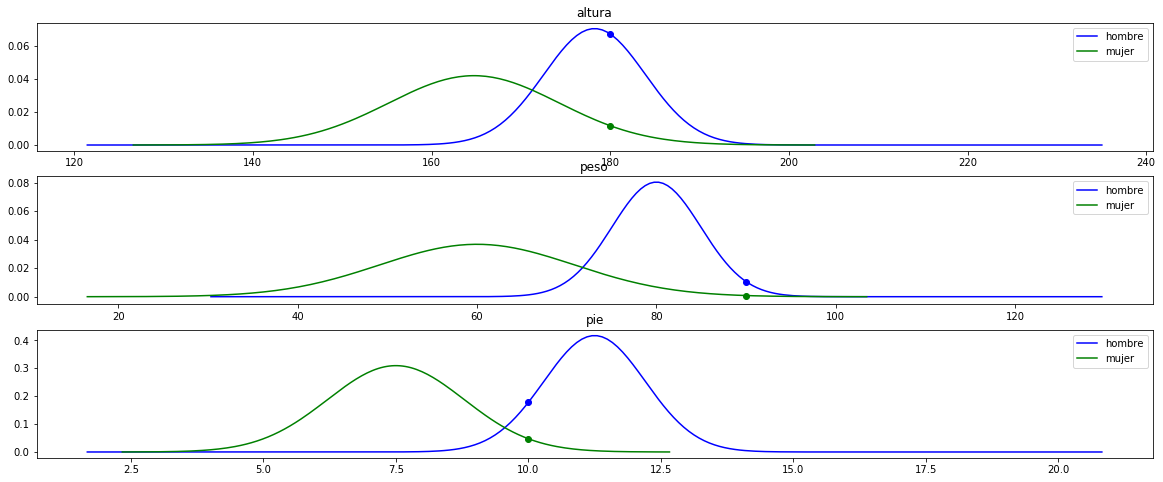

In [41]:
sample = np.array([180,90,10])

f, axs = plt.subplots(3, 1, sharey=False, sharex=False, figsize = (20,8))
keys = ['altura', 'peso','pie']
for i, ax in enumerate(axs):
    plot_gaussian(men_means[i], np.sqrt(men_vars[i]), ax=ax, N=10, color='b', label='hombre')
    plot_gaussian(women_means[i], np.sqrt(women_vars[i]), ax=ax, N=4, color='g', label='mujer')
    ax.scatter(sample[i], gaussian(sample[i], men_means[i], np.sqrt(men_vars[i])), color='b')
    ax.scatter(sample[i], gaussian(sample[i], women_means[i], np.sqrt(women_vars[i])), color='g')
    ax.title.set_text(keys[i])
    ax.legend()
plt.show()

In [42]:
p_hombre = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_hombre = gaussian(sample[0], men_means[0], np.sqrt(men_vars[0]))
p_peso_hombre = gaussian(sample[1], men_means[1], np.sqrt(men_vars[1]))
p_pie_hombre = gaussian(sample[2], men_means[2], np.sqrt(men_vars[2]))
posterior_hombre = p_hombre*p_altura_hombre*p_peso_hombre*p_pie_hombre
print('Posteriori de hombre:', posterior_hombre)

Posteriori de hombre: 6.29781391114e-05


In [43]:
p_mujer = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_mujer = gaussian(sample[0], women_means[0], np.sqrt(women_vars[0]))
p_peso_mujer = gaussian(sample[1], women_means[1], np.sqrt(women_vars[1]))
p_pie_mujer = gaussian(sample[2], women_means[2], np.sqrt(women_vars[2]))
posterior_mujer = p_mujer*p_altura_mujer*p_peso_mujer*p_pie_mujer
print('Posteriori de Mujer:', posterior_mujer)

Posteriori de Mujer: 2.2363824638e-07


In [44]:
if posterior_mujer>posterior_hombre:
    print('MUJER')
else:
    print('HOMBRE')

HOMBRE


Notar que no hace falta calcular el denominador

# Utilizando sklearn

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(GNB_features_matrix, GNB_labels)

In [47]:
samples = np.array([[180,90,10], [160, 70, 8], [178, 73, 9], [178, 74, 9]])
print(y_pred.predict(samples))
print(y_pred.predict_proba(samples))

score_train = gnb.score(GNB_features_matrix, GNB_labels)
print(score_train)

['hombre' 'mujer' 'mujer' 'hombre']
[[  9.99077440e-01   9.22560042e-04]
 [  3.59206251e-07   9.99999641e-01]
 [  4.34003950e-01   5.65996050e-01]
 [  5.59309521e-01   4.40690479e-01]]
1.0


## Problema 2
Utilizando las siguientes funciones/paquetes resolver los siguientes problemas de clasificación en **problema_2.py**:

**genfromtxt** de **numpy** para leer los dos datasets:
- ./datasets/student_admission.txt
- ./datasets/chip_tests.txt

**train_test_split** de **sklearn** para dividir entre test set y train set. Recomendamos un 40% de datos para test set

**GaussianNB** de **sklearn** como modelo de ML.

Y la función **plot_boundaries(X_train, X_test, y_train, y_test, score, predict_proba, ax=ax, h=h)** incluida en problema_2.py para graficar los resultados. X_train es un np.array con los features de entrada, y_train es la etiqueta. Lo mismo con X_test e y_test, Score es el 'accuracy' del modelo, predict_proba es la función que dada una entrada de la probabilidad de clasificar correcto y h es el paso para la grafica del 'boundary'